# Problema de Duración de viaje en Taxi

*target*: duracion del viaje  
Problema de **Regresion**

In [83]:
import scipy.io as sio
import scipy as sp
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold , metrics, tree
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering as hac
from sklearn.tree import DecisionTreeClassifier as Tree

from subprocess import check_call
from IPython.display import Image as PImage

In [84]:
def rmsle(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

def rmse(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = predicted[x]
        r = real[x]
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

def mse(predicted,real):
    suma=0.0
    for x in range(len(predicted)):
        p = predicted[x]
        r = real[x]
        suma += np.power((p - r),2)
    return suma/len(predicted)


In [85]:
#annadir grafico de real vs predecido
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.') #o punto
    
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.title("Compara Valor real con la prediccion")
    plt.show()

In [86]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134

para ver la cantidad de memoria de cada dataset

In [87]:
print("Dimensiones training set: ", df.shape)
print("Dimensiones test set: ", df_test.shape)
df.head()

('Dimensiones training set: ', (1458644, 11))
('Dimensiones test set: ', (625134, 9))


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [88]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [89]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


## Visualizar estadisticas

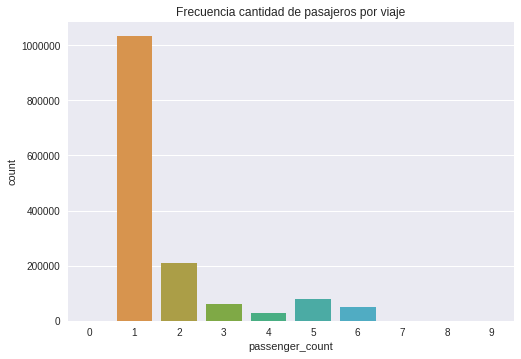

In [8]:
sns.countplot(x='passenger_count',data =df)#hue='store_and_fwd_flag')
plt.title('Frecuencia cantidad de pasajeros por viaje')
plt.show()

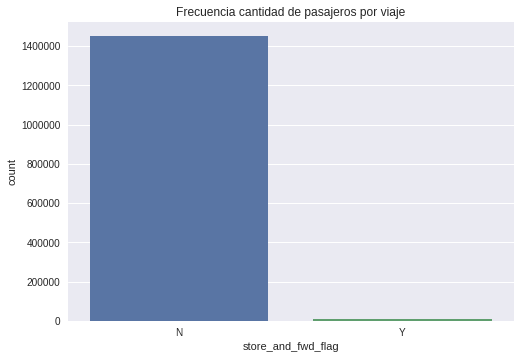

In [9]:
sns.countplot(x='store_and_fwd_flag',data =df)#hue='PTS_TYPE')
plt.title('Frecuencia cantidad de pasajeros por viaje')
plt.show()

### Analisis de la etiqueta

Valor minimo de duracion:  1
Valor maximo de duracion:  3526282


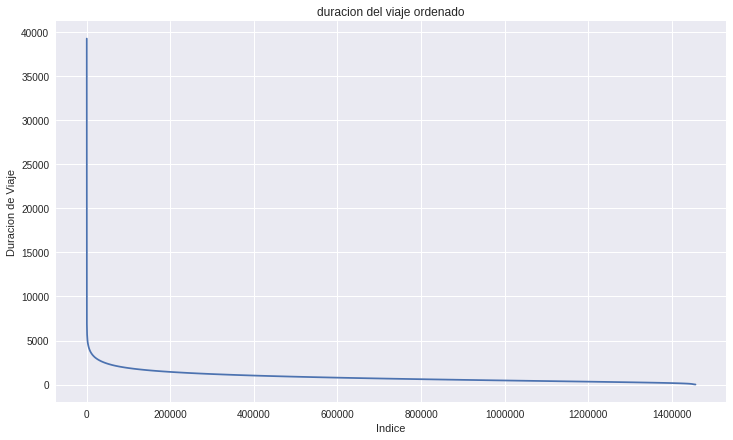

In [58]:
aux = np.sort(df['trip_duration'].values)[::-1]
print "Valor minimo de duracion: ", np.min(aux)
print "Valor maximo de duracion: ", np.max(aux)

plt.figure(figsize=(12,7))
plt.title("duracion del viaje ordenado")
plt.plot(aux[2000:])
plt.ylabel("Duracion de Viaje")
plt.xlabel("Indice")
plt.axis('tight')
plt.show()

In [59]:
output = df['trip_duration'].values

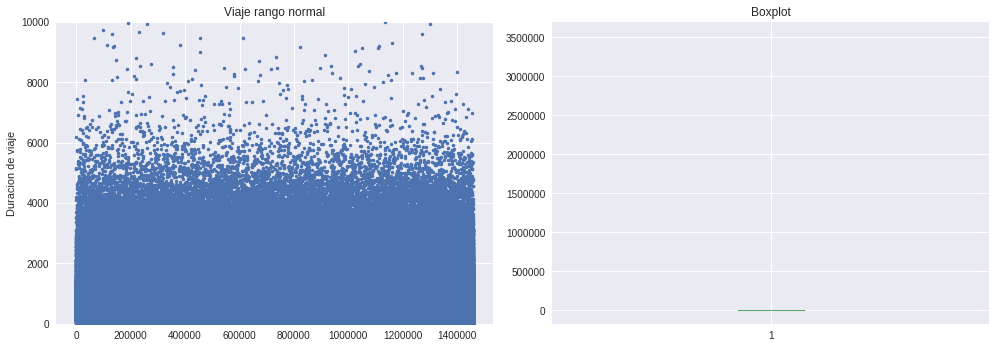

In [60]:
f, axarr = plt.subplots(1, 2,figsize=(14,5))
axarr[0].set_ylabel("Duracion de viaje")
axarr[0].plot(output,'.')
axarr[0].set_ylim(0,10000)
axarr[0].set_title("Viaje rango normal")

axarr[1].boxplot(output)
axarr[1].set_title("Boxplot")

f.tight_layout() #separar los subplot
plt.show()

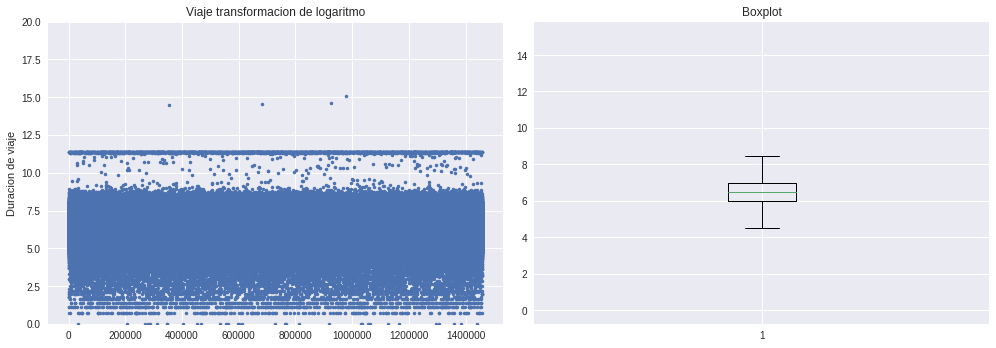

In [61]:
f, axarr = plt.subplots(1, 2,figsize=(14,5))
axarr[0].set_ylabel("Duracion de viaje")
axarr[0].plot(np.log(output),'.')
axarr[0].set_ylim(0,20)
axarr[0].set_title("Viaje transformacion de logaritmo")

axarr[1].boxplot(np.log(output))
axarr[1].set_title("Boxplot")

f.tight_layout() #separar los subplot
plt.show()

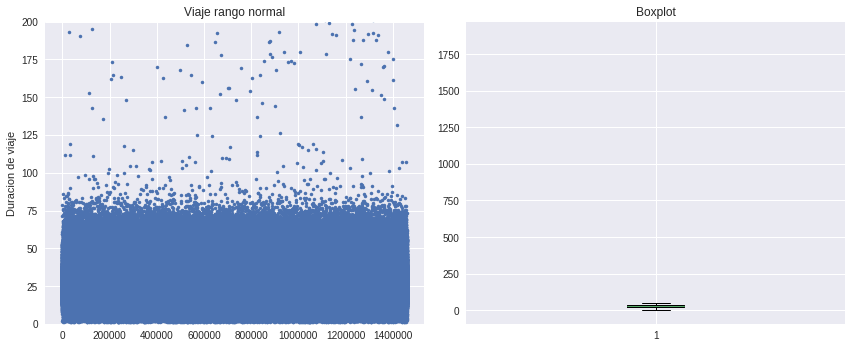

In [62]:
f, axarr = plt.subplots(1, 2,figsize=(12,5))
axarr[0].set_ylabel("Duracion de viaje")
axarr[0].plot(np.sqrt(output),'.')
axarr[0].set_ylim(0,200)
axarr[0].set_title("Duracion de viaje con raiz cuadrada")

axarr[1].boxplot(np.sqrt(output))
axarr[1].set_title("Boxplot")

f.tight_layout() #separar los subplot
plt.show()

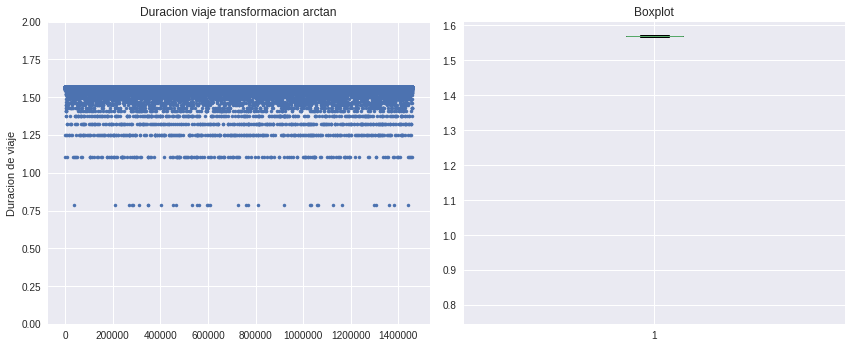

In [69]:
f, axarr = plt.subplots(1, 2,figsize=(12,5))
axarr[0].set_ylabel("Duracion de viaje")
axarr[0].plot(np.arctan(output),'.')
axarr[0].set_ylim(0,2)
axarr[0].set_title("Duracion viaje transformacion arctan")

axarr[1].boxplot(np.arctan(output))
axarr[1].set_title("Boxplot")

f.tight_layout() #separar los subplot
plt.show()

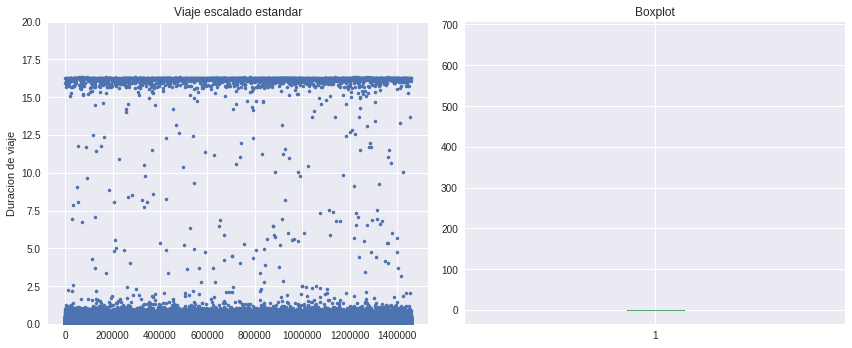

In [153]:
scaler = StandardScaler(with_mean=True, with_std=True)

scaler.fit(output.reshape(-1,1))
y_scaled = scaler.transform(output.reshape(-1,1))

f, axarr = plt.subplots(1, 2,figsize=(12,5))
axarr[0].set_ylabel("Duracion de viaje")
axarr[0].plot(y_scaled,'.')
axarr[0].set_ylim(0,20)
axarr[0].set_title("Viaje escalado estandar")

axarr[1].boxplot(y_scaled)
axarr[1].set_title("Boxplot")

f.tight_layout() #separar los subplot
plt.show()

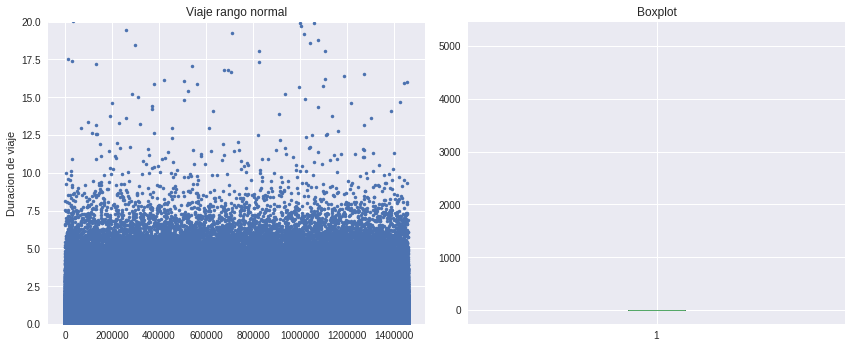

In [63]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)

scaler.fit(output.reshape(-1,1))
y_scaled = scaler.transform(output.reshape(-1,1))

f, axarr = plt.subplots(1, 2,figsize=(12,5))
axarr[0].set_ylabel("Duracion de viaje")
axarr[0].plot(y_scaled,'.')
axarr[0].set_ylim(0,20)
axarr[0].set_title("Viaje rango normal")

axarr[1].boxplot(y_scaled)
axarr[1].set_title("Boxplot")

f.tight_layout() #separar los subplot
plt.show()

## Visualizacion 2d

Valor minimo de longitud:  -121.93334198
Valor maximo de longitud:  -61.3355293274
Valor minimo de latitude:  32.1811408997
Valor maximo de latitude:  51.8810844421


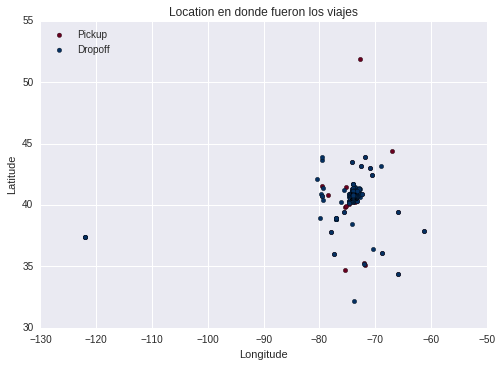

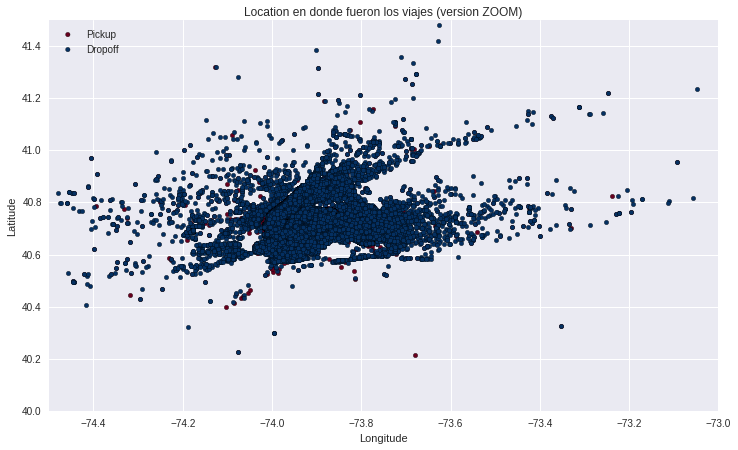

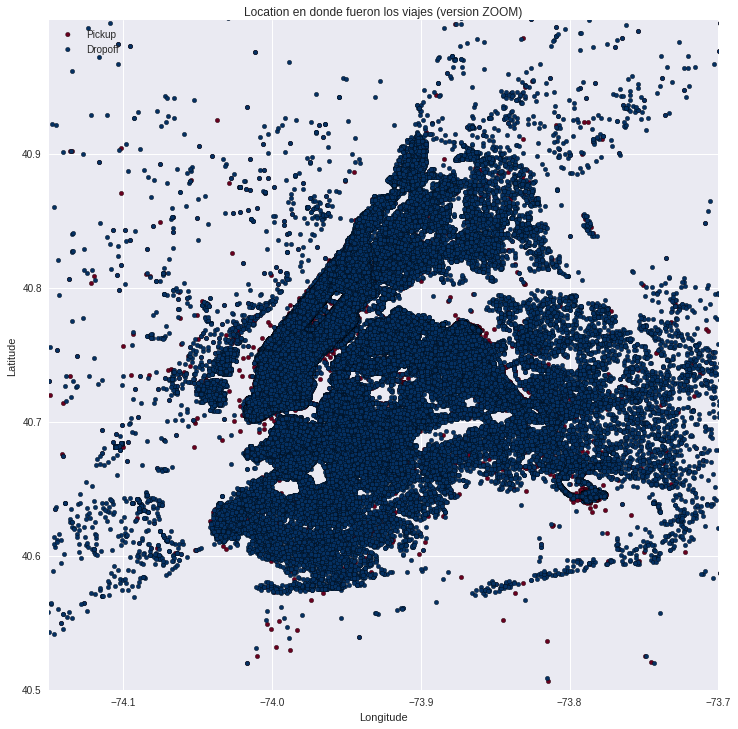

In [58]:
x1,x2 = df['pickup_longitude'].values, df['pickup_latitude'].values
y1,y2 = df['dropoff_longitude'].values, df['dropoff_latitude'].values

print "Valor minimo de longitud: ", np.min([x1,y1]) 
print "Valor maximo de longitud: ", np.max([x1,y1]) 
print "Valor minimo de latitude: ", np.min([x2,y2]) 
print "Valor maximo de latitude: ", np.max([x2,y2]) 

tipos = [0,1]
cmap = plt.cm.get_cmap(name = "RdBu") 
mcolors = [cmap(i) for i in np.linspace(0,1,2)]

plt.scatter(x1,x2,s=20,label="Pickup",c=mcolors[0])
plt.scatter(y1,y2,s=20,label="Dropoff",c=mcolors[1])

plt.title('Location en donde fueron los viajes')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

plt.clf()
plt.figure(figsize=(12,7))

plt.scatter(x1,x2,s=20,label="Pickup",c=mcolors[0])
plt.scatter(y1,y2,s=20,label="Dropoff",c=mcolors[1])

plt.xlim(-74.5,-73)
plt.ylim(40,41.5)

plt.title('Location en donde fueron los viajes (version ZOOM)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

plt.clf()
plt.figure(figsize=(12,12))

plt.scatter(x1,x2,s=20,label="Pickup",c=mcolors[0])
plt.scatter(y1,y2,s=20,label="Dropoff",c=mcolors[1])

plt.xlim(-74.15,-73.7)
plt.ylim(40.5,41)

plt.title('Location en donde fueron los viajes (version ZOOM)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

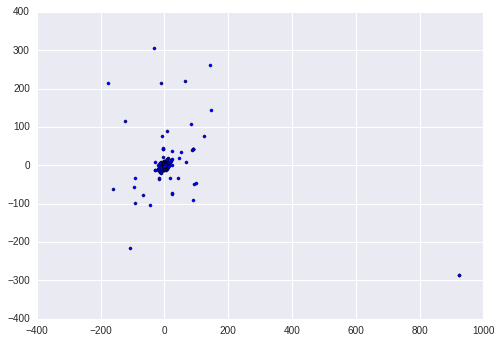

In [32]:
caract = df.ix[:,["passenger_count","pickup_longitude","pickup_latitude","dropoff_longitude",
                  "dropoff_latitude","trip_duration"]].values

#escalar
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(caract)
escalado = scaler.fit_transform(caract)

#model = manifold.TSNE(n_components = 2)
model = PCA(n_components = 2)
#model = manifold.SpectralEmbedding(n_components=2)

x2d = model.fit_transform(escalado)

plt.scatter(x2d[:,0],x2d[:,1],s=20)
plt.legend(loc='upper left')
plt.show()

Conclusion: La mayoría de los viajes duran lo mismo y son el mismo sector... teniendo una gran cantidad de outliers que podrian afectar la precision del algoritmo, por lo que se necesitara un algoritmo robusto a esto, o aplicar una transformacion , como logaritmica.

### Preprocesar dataset

In [90]:
from geopy.distance import great_circle
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360

In [91]:
#reemplazar Nan
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')

def preprocesar(df):
    df.fillna(0,inplace=True)

    #transformar fechas a tiempos
    #probar con sumar los segundos
    df['min'] = pd.to_datetime(df['pickup_datetime']).dt.minute
    df['min'] = pd.to_numeric(df['min'])

    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])

    #procesamiento de fecha(datetime-timestamp) a numeros
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek#0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])

    df['year'] = pd.to_datetime(df['pickup_datetime']).dt.year
    df['year'] = pd.to_numeric(df['year'])

    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])

    #caract agregada:
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude']))

    nueva_distancia = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km']=nueva_distancia

    #agregar direccion (en base a grado)
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    #viajes largos
    #df['viaje_largo'] = np.mean(df['distancia_viaje']) < df['distancia_viaje']

    #agregar temporada
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]
    
    #holidays
    df['holiday'] = df['pickup_datetime'].isin(holidays)
    
    #a categorico
    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype('category')
    df["holiday"] = df["holiday"].astype('category')

    #codifica
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

preprocesar(df)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,min,hour,cday,year,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,24,17,0,2016,3,0.017680,1.498943,99.970196,1,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,43,0,6,2016,6,0.020456,1.806016,242.846232,2,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,35,11,1,2016,1,0.059934,6.386897,200.319835,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,32,19,2,2016,4,0.013438,1.485917,187.262300,1,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,30,13,5,2016,3,0.010690,1.188923,179.473585,1,0


In [92]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,min,hour,cday,year,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644.0,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644.0
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,5.515396e-03,9.594923e+02,2.959016e+01,1.360648e+01,3.050375e+00,2016.0,3.516818e+00,3.548232e-02,3.441833e+00,1.534063e+02,8.397889e-01,0.0
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.406066e-02,5.237432e+03,1.732471e+01,6.399693e+00,1.954039e+00,0.0,1.681038e+00,4.596807e-02,4.297749e+00,1.042202e+02,6.751467e-01,0.0
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,0.000000e+00,3.970000e+02,1.500000e+01,9.000000e+00,1.000000e+00,2016.0,2.000000e+00,1.258443e-02,1.232184e+00,4.430475e+01,0.000000e+00,0.0
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,0.000000e+00,6.620000e+02,3.000000e+01,1.400000e+01,3.000000e+00,2016.0,4.000000e+00,2.121671e-02,2.094307e+00,1.685168e+02,1.000000e+00,0.0
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,0.000000e+00,1.075000e+03,4.500000e+01,1.900000e+01,5.000000e+00,2016.0,5.000000e+00,3.840884e-02,3.876429e+00,2.243612e+02,1.000000e+00,0.0
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.000000e+00,3.526282e+06,5.900000e+01,2.300000e+01,6.000000e+00,2016.0,6.000000e+00,1.119260e+01,1.241258e+03,3.599935e+02,2.000000e+00,0.0


### Visualizacion respecto a la hora+fecha

set([1, 2, 3, 4, 5, 6])
set([2016])


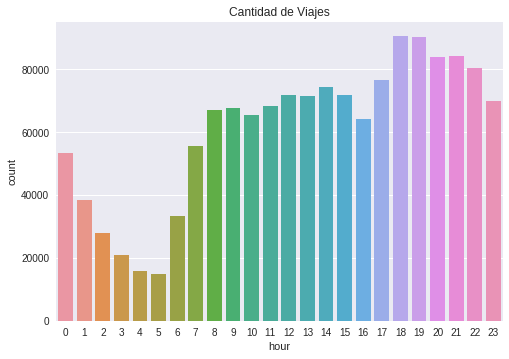

In [35]:
print set(df.month) #solo la primera mitad del anno... (revisar test set igual)
print set(df.year) #revisar test set... (esta caract se ppodria eliminar ya que nos e aprendera nada de tiempos futuros)

sns.countplot(x='hour',data =df)#, hue='passenger_count')
#sns.countplot(x='cday',data =df)#, hue='passenger_count')
#sns.countplot(x='month',data =df)#, hue='passenger_count')
plt.title("Cantidad de Viajes")
plt.show()

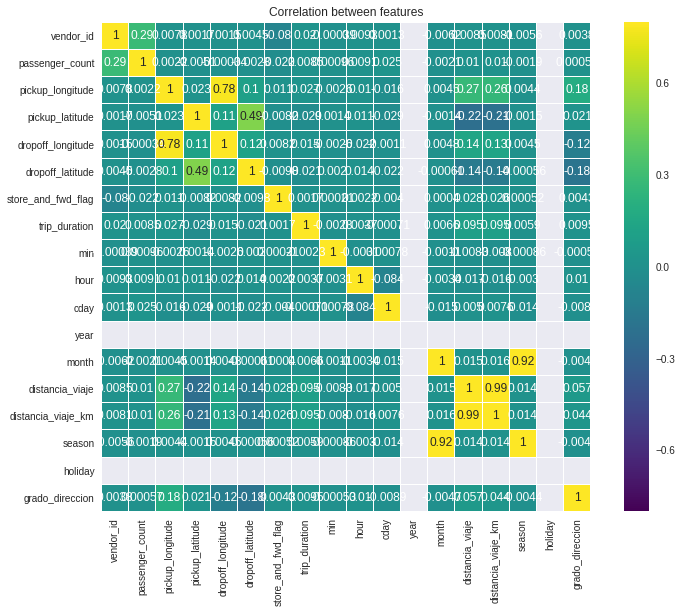

In [46]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlation between features');
plt.show()

es poco el tiempo en el cual se tiene el dataset, por lo que es posible que el tiempo no ayude mucho en predecir la etiqueta, por lo que pienso que fuertemente pueda depender de la posicion y respecto a la HORA.

**Idea para crear nuevas caract puede ser ver las cosas Iportantes que hay alrededor del pickup location** (habria que mirar un mapa)

In [108]:
#dataset.drop('CLOSEST_DEFENDER_PLAYER_ID',axis=1,inplace=True)
all_features = df.columns.values
print all_features

features = ["vendor_id","passenger_count","pickup_longitude","pickup_latitude","dropoff_longitude"
            ,"dropoff_latitude","store_and_fwd_flag","min","hour","cday","month","distancia_viaje",
            "distancia_viaje_km","grado_direccion","season","holiday"]

nuevas_features = ["distancia_viaje", "hour", "dropoff_latitude", "cday","grado_direccion", "vendor_id",
                   "pickup_longitude"]

features_red_neuronal = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude',
                    'dropoff_latitude','store_and_fwd_flag',"min","hour","cday","month", "season",
                     "distancia_viaje_km","grado_direccion"]
#ver que quitar... y sacarlo

X = df.loc[:,nuevas_features].values
Y = df.loc[:,'trip_duration'].values

#Y = target[:,1] #saca el id
#X = df_X[:,1:] #saca el id

print Y
print X
print X.shape

['id' 'vendor_id' 'pickup_datetime' 'dropoff_datetime' 'passenger_count'
 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'store_and_fwd_flag' 'trip_duration' 'min' 'hour'
 'cday' 'year' 'month' 'distancia_viaje' 'distancia_viaje_km'
 'grado_direccion' 'season' 'holiday']
[ 455  663 2124 ...,  764  373  198]
[[  1.76795395e-02   1.70000000e+01   4.07656021e+01 ...,   9.99701956e+01
    2.00000000e+00  -7.39821548e+01]
 [  2.04559039e-02   0.00000000e+00   4.07311516e+01 ...,   2.42846232e+02
    1.00000000e+00  -7.39804153e+01]
 [  5.99337994e-02   1.10000000e+01   4.07100868e+01 ...,   2.00319835e+02
    2.00000000e+00  -7.39790268e+01]
 ..., 
 [  7.63269339e-02   6.00000000e+00   4.07073708e+01 ...,   2.09211508e+02
    2.00000000e+00  -7.39591293e+01]
 [  1.09623176e-02   1.50000000e+01   4.07571068e+01 ...,   3.50332941e+01
    1.00000000e+00  -7.39820786e+01]
 [  1.11056524e-02   1.40000000e+01   4.07905846e+01 ...,   2.99694857e+01
    1.00000000e+00 

In [ ]:
#hacer algo aca...

### Crear conjunto de validacion

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
print "Tamaño de dataset de entrenamiento: ",X_train.shape
print "Tamaño de dataset de validacion: ",X_val.shape

Tamaño de dataset de entrenamiento:  (1021050, 7)
Tamaño de dataset de validacion:  (437594, 7)


### Escalar datos

In [70]:
#scaler = StandardScaler(with_mean=True, with_std=True)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [129]:
def transformar(valor):
    return np.log(valor+1)
    #return np.arctan(valor)
def destransformar(valor):
    epsilon =  1e-15
    pred = np.maximum(epsilon, valor)   
    pred = np.minimum(700,valor)
    return np.exp(pred) -1
    #return np.tan(valor)

def probar_normal(model):
    print "Sin Escalar"
    model.fit(X_train,transformar(y_train))

    print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
    print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)
    
def probar_escalado(model):
    print "Escalado"
    model.fit(X_train_scaled,transformar(y_train))

    print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
    print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val_scaled)),y_val)

In [224]:
##probar la extraccion de caract
def fss(x, y, xval,yval, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)+1
    names_x = np.array(names_x)
    remaining = range(0, p+1)
    selected = []
    current_score = 0.0
    best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = Tree(max_depth = 10)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            x_val = xval[:,indexes]

            predictions_val = model.fit(x_train, transformar(y)).predict(x_val)
            predictions_val = destransformar(predictions_val)
            
            kagg_val = rmsle(predictions_val,yval) #en base al evaluador kagg
            
            score_candidates.append((kagg_val, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop() #el de menor error es el mejor candidato
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
    return selected
        
new_names_features = fss(X_train,y_train,X_val,y_val,features)[:8]
#mostrar cuales se eliminaron
new_names_features = np.asarray(features)[new_names_features]
print "se eliminaron"
x = set(features)
y = x - set(new_names_features)
print y

selected = distancia_viaje ...
selected = hour ...
selected = dropoff_latitude ...
selected = cday ...
selected = grado_direccion ...
selected = vendor_id ...
selected = pickup_longitude ...
selected = distancia_viaje_km ...
selected = pickup_latitude ...
selected = holiday ...
selected = season ...
selected = month ...
selected = min ...
selected = store_and_fwd_flag ...
selected = dropoff_longitude ...
selected = passenger_count ...
se eliminaron
set(['min', 'season', 'month', 'dropoff_longitude', 'passenger_count', 'store_and_fwd_flag', 'holiday', 'pickup_latitude'])


In [130]:
from sklearn.tree import DecisionTreeRegressor as Tree
model = Tree(max_depth=10)
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

ERROR RMSLE de training:  0.476058648228
ERROR RMSLE de validacion:  0.482441726303


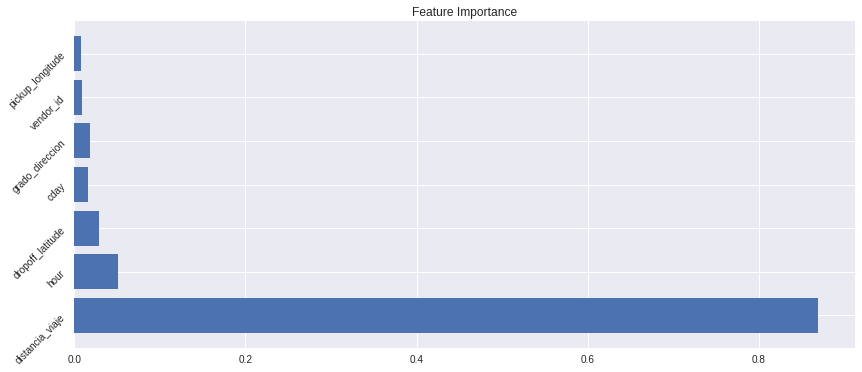

In [114]:
plt.figure(figsize=(14,6))
plt.barh(range(len(nuevas_features)), model.feature_importances_)
plt.yticks(range(len(nuevas_features)),nuevas_features, rotation= 45)
plt.title('Feature Importance')
plt.show()

In [115]:
tree.export_graphviz(model,  out_file='tree.dot',
                    feature_names = features,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )

#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

plt.figure(figsize=(12,12))
PImage(filename='tree.png')

ValueError: Length of feature_names, 16 does not match number of features, 7

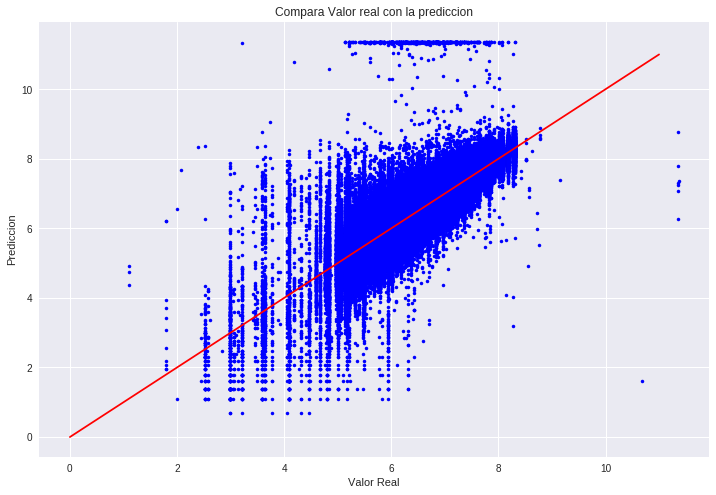

In [116]:
#graficar_predicciones(destransformar(model.predict(X_val)),y_val)
graficar_predicciones(model.predict(X_val),transformar(y_val))

### -> Random Forest

In [117]:
from sklearn.ensemble import RandomForestRegressor as RE
profundidades = [5,10,15,20,25,30]
for d in profundidades:
    print "Para la profundidad ",d

    model = RE(max_depth=d,n_jobs=-1)
    probar_normal(model) #probar con datos no escalados
    
    #model = RE(max_depth=d,n_jobs=-1)
    #probar_escalado(model) #probar con datos escalados


#agregar n_estimators=10 al mejor

#model.fit(X_train,y_train)

#print "ERROR RMSLE de training: ", rmsle(model.predict(X_train),y_train)
#print "ERROR RMSLE de validacion: ", rmsle(model.predict(X_val),y_val)

Para la profundidad  5
Sin Escalar
ERROR RMSLE de training:  0.481052503215
ERROR RMSLE de validacion:  0.515794174522
Para la profundidad  10
Sin Escalar
ERROR RMSLE de training:  0.430313217942
ERROR RMSLE de validacion:  0.436439770935
Para la profundidad  15
Sin Escalar
ERROR RMSLE de training:  0.366485289732
ERROR RMSLE de validacion:  0.425998029974
Para la profundidad  20
Sin Escalar
ERROR RMSLE de training:  0.277941125546
ERROR RMSLE de validacion:  0.415515742136
Para la profundidad  25
Sin Escalar
ERROR RMSLE de training:  0.211499827417
ERROR RMSLE de validacion:  0.419758958398
Para la profundidad  30
Sin Escalar
ERROR RMSLE de training:  0.185684626859
ERROR RMSLE de validacion:  0.421246376156


**Idea**: a mayor profundidad, mayor discernición entre los distintos grupos de viajes (muy largos, largos, medianos, cortos, muy cortos)

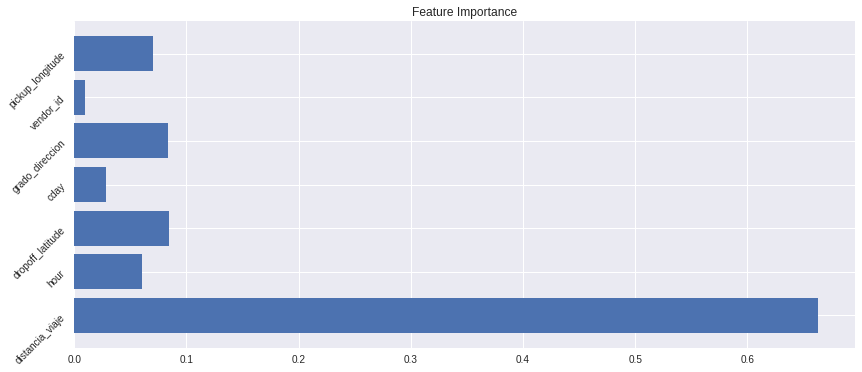

In [118]:
plt.figure(figsize=(14,6))
plt.barh(range(len(nuevas_features)), model.feature_importances_)
plt.yticks(range(len(nuevas_features)),nuevas_features, rotation= 45)
plt.title('Feature Importance')
plt.show()

In [122]:
model = RE(max_depth=20,n_jobs=-1,n_estimators=30)
probar_normal(model) #probar con datos no escalados

Sin Escalar
ERROR RMSLE de training:  0.269245243282
ERROR RMSLE de validacion:  0.406808152722


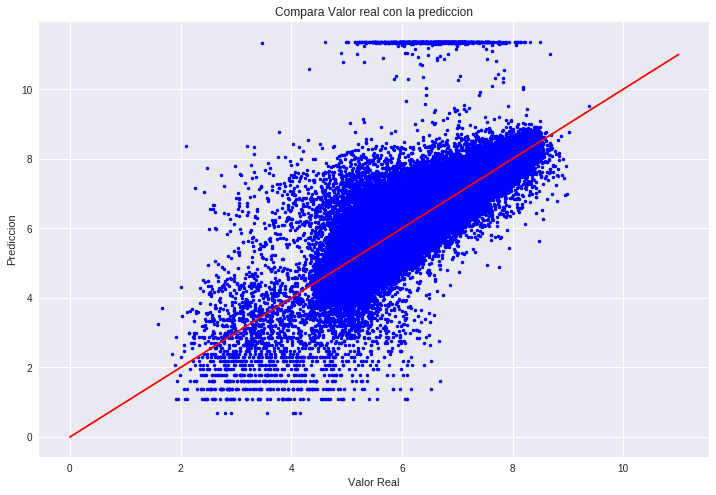

In [123]:
#graficar_predicciones(destransformar(model.predict(X_val)),y_val)
graficar_predicciones(model.predict(X_val),transformar(y_val))

In [26]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

ERROR RMSLE de training:  0.372681292825
ERROR RMSLE de validacion:  0.533950055645


ERROR RMSLE de training:  0.227543986351
ERROR RMSLE de validacion:  0.427533680907


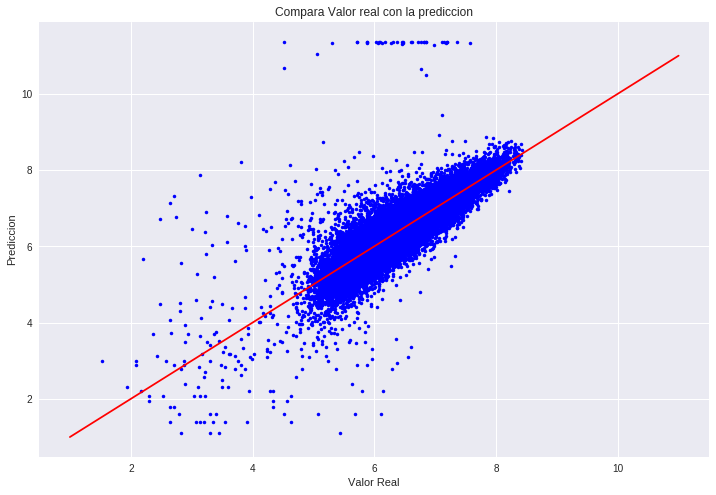

In [51]:
from sklearn.ensemble import AdaBoostRegressor as ADA
model = ADA(Tree(max_depth=15))
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

graficar_predicciones(model.predict(X_val),transformar(y_val))

In [ ]:
from sklearn.svm import SVR
model = SVR(verbose=True,cache_size=7000)
model.fit(X_train_scaled,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val_scaled)),y_val)

[LibSVM]

## Regresion lineal (para probar):

In [52]:
from sklearn.linear_model import LinearRegression as LR
model = LR(fit_intercept=True, normalize=True, n_jobs=-1)
model.fit(X_train,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val)),y_val)

ERROR RMSLE de training:  0.611063123387
ERROR RMSLE de validacion:  0.620149916758


In [57]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.6)
model.fit(X_train_scaled,transformar(y_train))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val_scaled)),y_val)

ERROR RMSLE de training:  0.611063123397
ERROR RMSLE de validacion:  0.620098430442


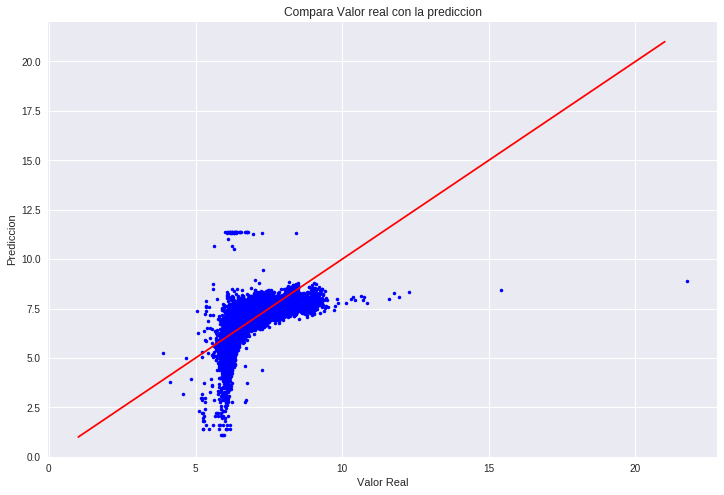

In [60]:
graficar_predicciones(model.predict(X_val),transformar(y_val))

Claramente no es con regresion lineal -,-

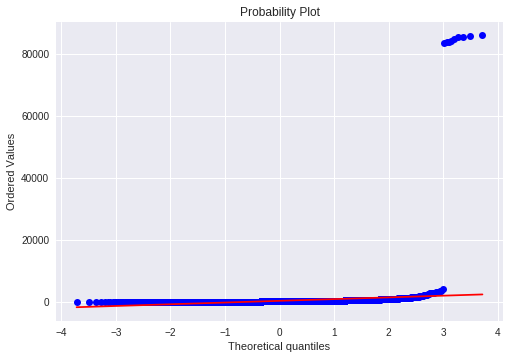

In [110]:
yhat_train = destransformar(model.predict(X_train_scaled))
residuo = np.abs(yhat_train - y_train)

from scipy import stats
res = stats.probplot(residuo, plot=plt)
plt.show()

### Red neuronal:

In [96]:
def graficar_historial(hist):
    history_dict = hist.history
    
    loss_values = history_dict['loss']
    if 'val_loss' in history_dict:
        val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    f, axarr = plt.subplots(1, 1, figsize=(14,5) )
    colors = ['#0B9014','#D20BD2']*4
    axarr.plot(epochs, loss_values, 'bo-', label = "Training set")
    if 'val_loss' in history_dict:
        axarr.plot(epochs, val_loss_values, 'g+-', label = "Test set")
    axarr.set_title('Loss de entrenamiento')
    axarr.set_ylim(0)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')
    axarr.legend(loc="center right", fancybox= True)

    f.tight_layout() #separar los subplot
    plt.show()

In [97]:
#cambiar el sscaler
from sklearn.preprocessing import RobustScaler,StandardScaler
#scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [17]:
#probar red neuronal
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
# model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1,validation_data=(X_test,y_test),callbacks=[stop])

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

model.compile(optimizer='RMSprop', loss="mean_squared_logarithmic_error",metrics=['acc']) #RMSprop, Adam
model.fit(X_train_scaled, y_train, epochs=20, batch_size=100, verbose=1,validation_data=(X_val_scaled,y_val))

Using TensorFlow backend.


Train on 1021050 samples, validate on 437594 samples
Epoch 1/20
1021050/1021050 [==============================] - 15s - loss: 2.1489 - acc: 8.0212e-04 - val_loss: 0.6228 - val_acc: 8.8667e-04
Epoch 2/20
1021050/1021050 [==============================] - 15s - loss: 0.6159 - acc: 8.4619e-04 - val_loss: 0.5962 - val_acc: 9.4608e-04
Epoch 3/20
1021050/1021050 [==============================] - 15s - loss: 0.5806 - acc: 8.4619e-04 - val_loss: 0.5539 - val_acc: 8.9581e-04
Epoch 4/20
1021050/1021050 [==============================] - 16s - loss: 0.5268 - acc: 0.0010 - val_loss: 0.4948 - val_acc: 0.0011
Epoch 5/20
1021050/1021050 [==============================] - 15s - loss: 0.4776 - acc: 0.0011 - val_loss: 0.4523 - val_acc: 0.0011
Epoch 6/20
1021050/1021050 [==============================] - 15s - loss: 0.4391 - acc: 0.0012 - val_loss: 0.4162 - val_acc: 0.0012
Epoch 7/20
1021050/1021050 [==============================] - 15s - loss: 0.4079 - acc: 0.0012 - val_loss: 0.3885 - val_acc: 0.0013

In [22]:
#probar cambiando funcion activacion

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

model.compile(optimizer='RMSprop', loss="mean_squared_logarithmic_error",metrics=['acc']) #RMSprop, Adam
model.fit(X_train_scaled, y_train, epochs=20, batch_size=100, verbose=1,validation_data=(X_val_scaled,y_val))

Train on 1021050 samples, validate on 437594 samples
Epoch 1/20
1021050/1021050 [==============================] - 16s - loss: 1.7641 - acc: 9.8918e-04 - val_loss: 0.3703 - val_acc: 0.0014
Epoch 2/20
1021050/1021050 [==============================] - 15s - loss: 0.3330 - acc: 0.0014 - val_loss: 0.2947 - val_acc: 0.0015
Epoch 3/20
1021050/1021050 [==============================] - 15s - loss: 0.2876 - acc: 0.0016 - val_loss: 0.2638 - val_acc: 0.0017
Epoch 4/20
1021050/1021050 [==============================] - 15s - loss: 0.2744 - acc: 0.0017 - val_loss: 0.2588 - val_acc: 0.0018
Epoch 5/20
1021050/1021050 [==============================] - 15s - loss: 0.2702 - acc: 0.0017 - val_loss: 0.2551 - val_acc: 0.0018
Epoch 6/20
1021050/1021050 [==============================] - 15s - loss: 0.2669 - acc: 0.0017 - val_loss: 0.2502 - val_acc: 0.0018
Epoch 7/20
1021050/1021050 [==============================] - 15s - loss: 0.2630 - acc: 0.0018 - val_loss: 0.2473 - val_acc: 0.0018
Epoch 8/20
1021050/

In [54]:
#agregar mas profundidad

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=['acc']) #RMSprop, Adam
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=100, verbose=1,validation_data=(X_val_scaled,y_val))

#relu y sigmoid andan igual 0.42-0.43

Train on 1021050 samples, validate on 437594 samples
Epoch 1/20
1021050/1021050 [==============================] - 32s - loss: 0.4139 - acc: 0.0017 - val_loss: 0.2436 - val_acc: 0.0017
Epoch 2/20
1021050/1021050 [==============================] - 30s - loss: 0.2519 - acc: 0.0017 - val_loss: 0.2233 - val_acc: 0.0021
Epoch 3/20
1021050/1021050 [==============================] - 31s - loss: 0.2390 - acc: 0.0018 - val_loss: 0.2122 - val_acc: 0.0020
Epoch 4/20
1021050/1021050 [==============================] - 30s - loss: 0.2292 - acc: 0.0019 - val_loss: 0.2040 - val_acc: 0.0019
Epoch 5/20
1021050/1021050 [==============================] - 30s - loss: 0.2231 - acc: 0.0019 - val_loss: 0.2033 - val_acc: 0.0019
Epoch 6/20
1021050/1021050 [==============================] - 32s - loss: 0.2185 - acc: 0.0020 - val_loss: 0.1953 - val_acc: 0.0022
Epoch 7/20
1021050/1021050 [==============================] - 30s - loss: 0.2148 - acc: 0.0020 - val_loss: 0.1932 - val_acc: 0.0022
Epoch 8/20
1021050/1021

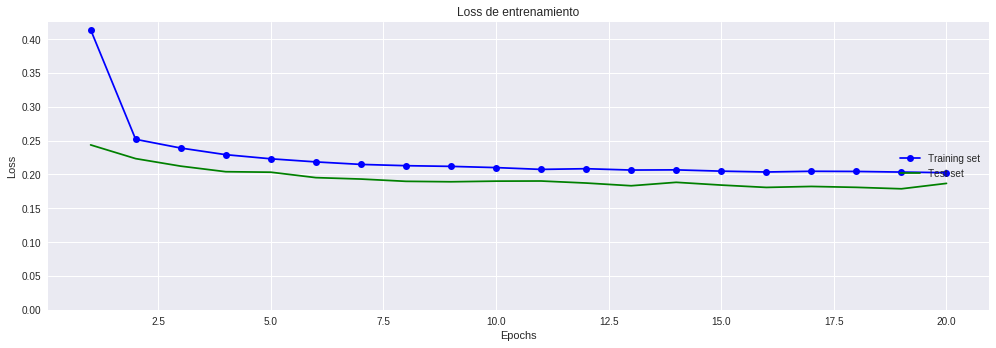

In [55]:
graficar_historial(history)

ERROR RMSLE de training:  0.432162222335
ERROR RMSLE de validacion:  0.432167652436


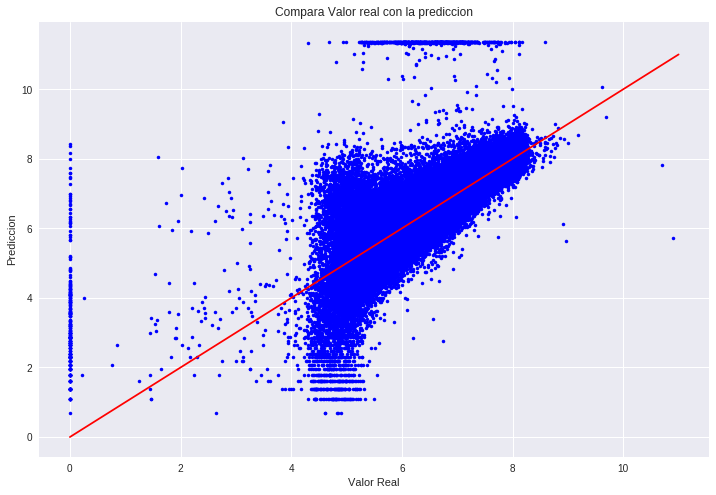

In [56]:
print "ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled).reshape(1,-1)[0],y_train)
print "ERROR RMSLE de validacion: ", rmsle(model.predict(X_val_scaled).reshape(1,-1)[0],y_val)

graficar_predicciones(transformar(model.predict(X_val_scaled)),transformar(y_val))

In [74]:
#transformar a mano el output

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

model.compile(optimizer='rmsprop', loss="mse",metrics=['acc']) #RMSprop, Adam
history = model.fit(X_train_scaled, transformar(y_train), epochs=10, batch_size=100, verbose=1,
                    validation_data=(X_val_scaled,transformar(y_val)))

Train on 1021050 samples, validate on 437594 samples
Epoch 1/10
1021050/1021050 [==============================] - 25s - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 2.5119e-04 - val_acc: 0.0000e+00
Epoch 2/10
1021050/1021050 [==============================] - 25s - loss: 1.1478e-04 - acc: 0.0000e+00 - val_loss: 8.7609e-05 - val_acc: 0.0000e+00
Epoch 3/10
1021050/1021050 [==============================] - 25s - loss: 1.2756e-04 - acc: 0.0000e+00 - val_loss: 8.3925e-05 - val_acc: 0.0000e+00
Epoch 4/10
1021050/1021050 [==============================] - 25s - loss: 1.0219e-04 - acc: 0.0000e+00 - val_loss: 1.2889e-04 - val_acc: 0.0000e+00
Epoch 5/10
1021050/1021050 [==============================] - 26s - loss: 1.2993e-04 - acc: 0.0000e+00 - val_loss: 8.4191e-05 - val_acc: 0.0000e+00
Epoch 6/10
1021050/1021050 [==============================] - 25s - loss: 1.1365e-04 - acc: 0.0000e+00 - val_loss: 1.7060e-04 - val_acc: 0.0000e+00
Epoch 7/10
1021050/1021050 [==============================] - 2

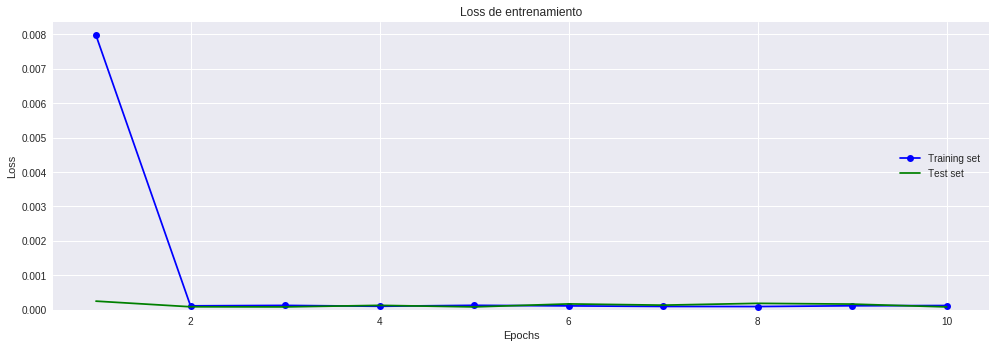

In [75]:
graficar_historial(history)

ERROR RMSLE de training: 

/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


 nan
ERROR RMSLE de validacion:  nan


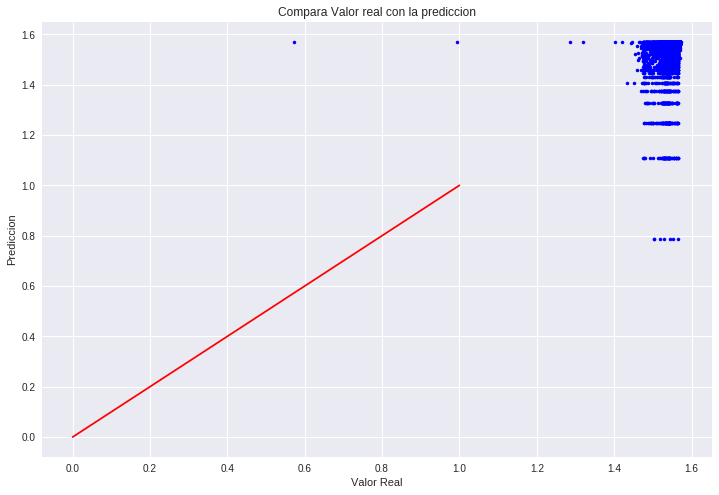

In [78]:
print "ERROR RMSLE de training: ", rmsle( destransformar(model.predict(X_train_scaled).reshape(1,-1)[0]),y_train)
print "ERROR RMSLE de validacion: ", rmsle(destransformar(model.predict(X_val_scaled).reshape(1,-1)[0]),y_val)

graficar_predicciones(model.predict(X_val_scaled),transformar(y_val))

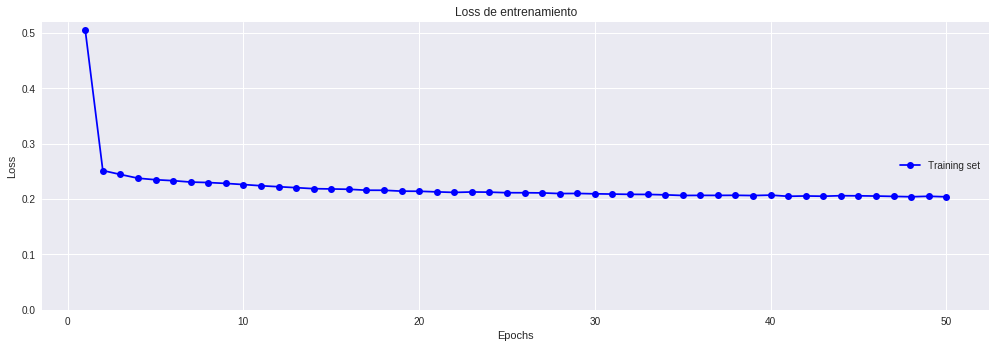

ERROR RMSLE:  0.427064436437


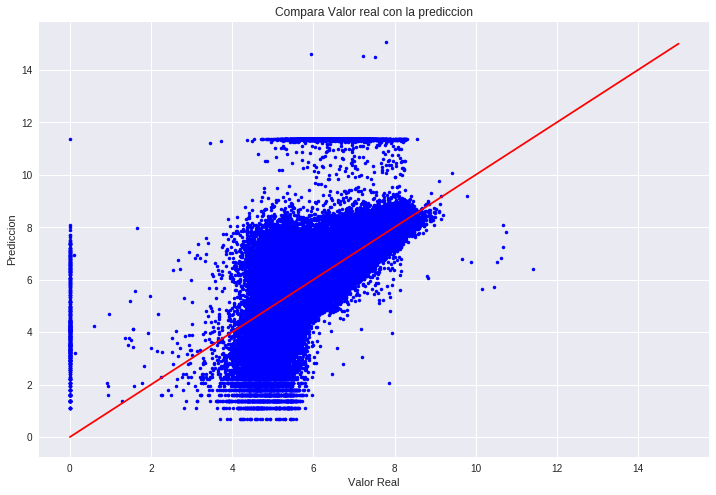

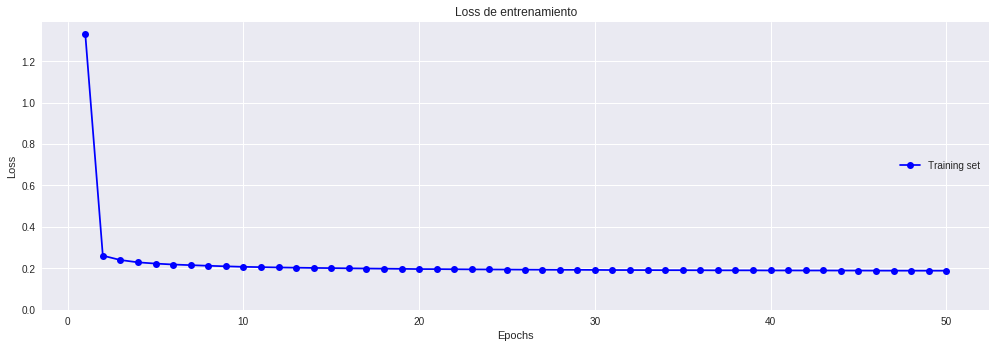

ERROR RMSLE:  0.422354463263


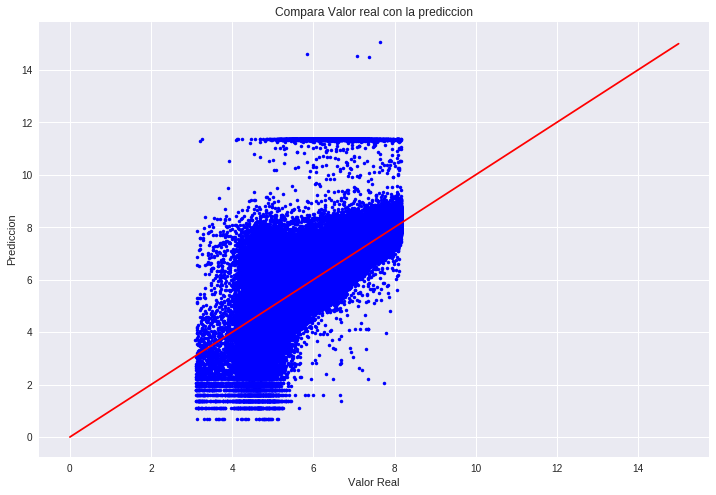

In [98]:
#elegir el mejor entrenarlo por harto rato, ver su grafico y mejorar

#agregar otra capa

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)
X_entero_escalado=scaler.fit_transform(X)

model = Sequential()
model.add(Dense(100, input_dim=X_entero_escalado.shape[1], kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer="uniform", activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='relu'))

model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=['acc']) #RMSprop, Adam
history = model.fit(X_entero_escalado, Y, epochs=50, batch_size=100, verbose=0)
graficar_historial(history)

print "ERROR RMSLE: ", rmsle( model.predict(X_entero_escalado).reshape(1,-1)[0],Y)

graficar_predicciones(transformar(model.predict(X_entero_escalado)),transformar(Y))


model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer="uniform", activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer="uniform", activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))

model.compile(optimizer='rmsprop', loss="mean_squared_logarithmic_error",metrics=['acc']) #RMSprop, Adam
history = model.fit(X_entero_escalado, Y, epochs=50, batch_size=100, verbose=0)
graficar_historial(history)

print "ERROR RMSLE: ", rmsle( model.predict(X_entero_escalado).reshape(1,-1)[0],Y)

graficar_predicciones(transformar(model.predict(X_entero_escalado)),transformar(Y))

#### Codigo para hacer la entrega:

In [125]:
model = RE(max_depth=20,n_jobs=-1,n_estimators=30)
model.fit(X,transformar(Y)) #entrenar con todo el training

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [124]:
preprocesar(df_test)

#cargar caract con las que se entreno el modelo
X_test = df_test.iloc[:,nuevas_features].values

/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [126]:
ids_test = df_test.id
target_test = destransformar(model.predict(X_test))


d = {'id': ids_test, 'trip_duration': target_test}

entrega = pd.DataFrame(data=d)
#redondear a entero
entrega['trip_duration'] = entrega.trip_duration.round(0).astype(int)
entrega.head()

,id,trip_duration
0,id3004672,761
1,id3505355,653
2,id1217141,462
3,id2150126,1030
4,id1598245,403


In [127]:
entrega.to_csv('Miterceraentrega.csv', index=False)